# Course 6 - tf-idf and Word2vec

## Import librairies and dataset

In [ ]:
#!pip install pandas seaborn matplotlib scikit-learn gensim eli5 tiktoken spacy gensim

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from nltk import word_tokenize, sent_tokenize          
from nltk.stem import WordNetLemmatizer 
import tiktoken
import eli5
import numpy as np

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

/home/gcortal/anaconda3/envs/epita/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gcortal/anaconda3/envs/epita/lib/python3.9/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025831482/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
dataset = load_dataset("gustavecortal/DreamBank-annotated")
df = dataset["train"].to_pandas()
df = df.sample(frac = 1)
df["report"] = df["report"].astype(str)
df = df.query("emotion == 'CO D' or emotion == 'AN D' or emotion == 'SD D' or emotion == 'AP D' or emotion == 'HA D'")[["report", "emotion"]]
df.head()

,report,emotion
1268,"I am in a wheelchair, going to a doctor's appo...",AN D
15038,I was studying somewhere. My chemistry exam wa...,AP D
20615,My first thought on being awakened was that it...,HA D
4563,"[""Juvies defy me.""] I am a substitute teacher ...",HA D
26969,It was a dream where I was at a pizza place an...,AN D


## Preprocessing and visualization

Convert code to emotion class according to the annotation guideline : https://dreams.ucsc.edu/Coding/emotions.html

In [3]:
def to_emotion_class(emotion):
    
    if emotion == "AP D":
        return "fear"
    elif emotion == "CO D":
        return "confusion"
    elif emotion == "SD D":
        return "sadness"
    elif emotion == "AN D":
        return "anger"
    else:
        return "happiness"

df["emotion"] = df["emotion"].apply(lambda x: to_emotion_class(x))
df["report"] = df["report"].apply(lambda x: x.lower()) # simple preprocessing (lowercase only)
df.head()

,report,emotion
1268,"i am in a wheelchair, going to a doctor's appo...",anger
15038,i was studying somewhere. my chemistry exam wa...,fear
20615,my first thought on being awakened was that it...,happiness
4563,"[""juvies defy me.""] i am a substitute teacher ...",happiness
26969,it was a dream where i was at a pizza place an...,anger


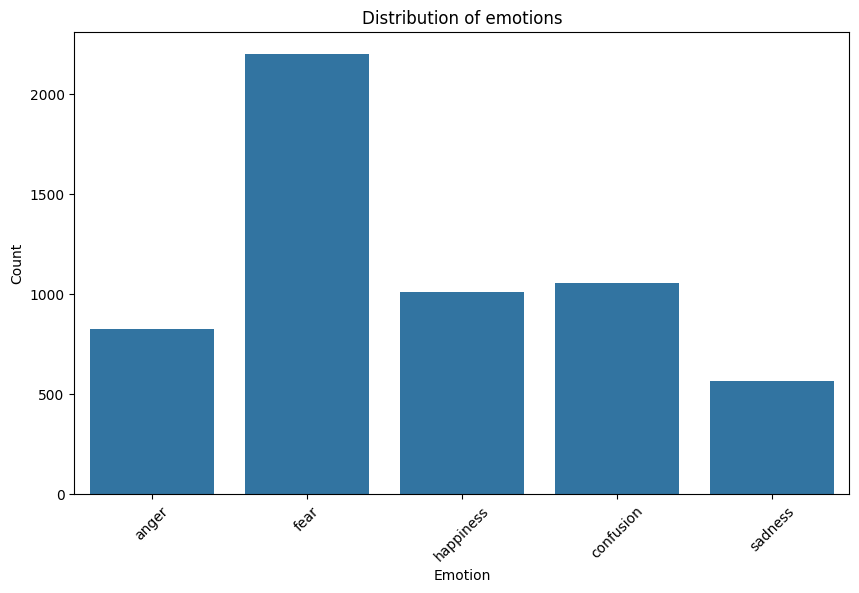

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=df)

plt.title('Distribution of emotions') 
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

## Training Word2vec

In [5]:
X_list = list(df["report"])
X_strings = " ".join(X_list)
X_sents = sent_tokenize(X_strings)
X_sents = [word_tokenize(s) for s in X_sents]

In [6]:
model = Word2Vec(sentences=X_sents, vector_size=50, window=5, min_count=5, workers=4)
#model = Word2Vec(sentences=X_sents, vector_size=100, window=5, min_count=5, workers=4)

word_vectors = model.wv
word_vectors.save("word2vec.wordvectors") # Store the words and their trained embeddings
del model

In [7]:
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
vector = wv['war']
sims = wv.most_similar('school', topn=10)
sims

[('college', 0.8511099219322205),
 ('university', 0.7597227096557617),
 ('westport', 0.7338651418685913),
 ('church', 0.6870197057723999),
 ('library', 0.6676742434501648),
 ('party', 0.6627900004386902),
 ('hospital', 0.6624340415000916),
 ('class', 0.6420021653175354),
 ('city', 0.6385878920555115),
 ('meeting', 0.6381309628486633)]

### Load pretrained Word2vec models

In [33]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [34]:
pretrained_wv = gensim.downloader.load('glove-twitter-100')
print(pretrained_wv.most_similar('kevin'))
print(pretrained_wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1))

[('chris', 0.8121618032455444), ('james', 0.7955256700515747), ('joe', 0.7932372689247131), ('mike', 0.7850410342216492), ('anthony', 0.7785152792930603), ('ryan', 0.7772720456123352), ('josh', 0.7681067585945129), ('danny', 0.7669281959533691), ('martin', 0.7561131119728088), ('tony', 0.7466763854026794)]
[('queen', 0.7052316069602966)]


In [43]:
pretrained_wv

### Embed documents using Word2vec

In [8]:
def document_vector(doc, wv):
    """Create document vectors by averaging word vectors."""
    words = word_tokenize(doc)
    word_vectors = np.array([wv[word] for word in words if word in wv])
    
    if len(word_vectors) == 0:
        return np.zeros(wv.vector_size)
    return np.mean(word_vectors, axis=0)

In [9]:
document_vector("hello i'm gustave", wv)

array([-0.19194837,  1.1887726 , -2.1477344 ,  0.7124633 ,  1.1299831 ,
       -0.11799113,  0.7068214 , -0.39063868, -0.10425514,  0.21563089,
        0.94921374, -1.0753573 ,  0.6847231 , -0.32946968, -0.53923285,
        0.07936132, -0.07657174,  0.76442164, -1.6217905 ,  0.391741  ,
        0.16873388, -0.01694202,  0.49370804, -1.440395  , -0.11706392,
       -1.6728534 ,  1.3412911 ,  0.9000004 , -1.4966612 ,  0.8223381 ,
       -0.14448702,  0.03353437, -0.14093874,  0.23752153, -0.1258779 ,
       -0.88438517, -0.2879149 ,  0.22302659, -0.50727063, -0.46047762,
       -1.0095145 , -0.03910244, -0.49541214,  0.3163128 , -0.6720114 ,
       -0.24253581, -0.5839502 , -0.88826936, -1.5413691 ,  1.1487356 ],
      dtype=float32)

In [37]:
document_vector("hello i'm gustave", pretrained_wv)

array([ 1.06234513e-02,  3.72975022e-02, -8.76264870e-02,  1.91324979e-01,
       -3.21467996e-01, -1.96269993e-02,  8.25392380e-02, -1.26881510e-01,
        2.30521262e-01,  3.14925052e-02, -3.52858752e-02, -3.11605006e-01,
       -3.27135992e+00, -9.83899981e-02, -1.58699974e-02,  1.59127504e-01,
        8.28345045e-02,  7.97371566e-03, -3.28304976e-01, -1.46375000e-01,
        8.91950056e-02, -6.60991013e-01, -1.90470219e-02, -4.90215003e-01,
        1.10356249e-01, -5.24932504e-01,  1.25850271e-03,  2.64232486e-01,
        3.58432502e-01, -5.27852535e-01, -1.72123998e-01,  1.99335009e-01,
       -3.29671502e-01, -1.07807502e-01, -7.35374987e-02,  4.31460068e-02,
       -1.23240992e-01,  1.02078997e-01,  4.95415002e-01,  2.15272516e-01,
       -8.49732518e-01, -8.40062499e-02, -1.17344998e-01, -1.06314242e-01,
       -1.62129961e-02,  1.71487495e-01, -6.80849999e-02, -5.87677538e-01,
       -2.82429934e-01,  2.15227500e-01, -1.54695019e-01,  5.20460531e-02,
       -2.09272504e-01, -

## Training and test sets for Word2vec

In [11]:
X = df['report']
y = df['emotion']

X = np.array([document_vector(text, wv) for text in X])
#X = np.array([document_vector(text, pretrained_wv) for text in X])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Features dimension: {X_train.shape}")

Features dimension: (4520, 50)


## Training and test sets for tf-idf

In [65]:
X = df['report']
y = df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

## Tokenization functions

In [12]:
def lemma_tokenize(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in word_tokenize(doc)]

def char_tokenize(doc):
    return [char for char in doc]

def byte_tokenize(doc):
    tokens = doc.encode("utf-8")
    tokens = list(map(int, tokens))
    return [str(token) for token in tokens]

def gpt_tokenize(doc):
    enc = tiktoken.encoding_for_model("gpt-4")
    tokens = enc.encode(doc)
    return [str(token) for token in tokens]

## Training: Logistic Regression with tf-idf or Word2vec features

In [13]:
model = LogisticRegression(random_state=42, penalty = 'l2', max_iter = 1000, class_weight='balanced')
#model = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range = (1,1)), LogisticRegression(random_state=42, class_weight='balanced', penalty = 'l1', max_iter = 1000))
#model = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range = (1,1)), TfidfTransformer(), LogisticRegression(random_state=42, class_weight='balanced', penalty = 'l1', max_iter = 1000))

In [14]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       anger       0.23      0.34      0.28       158
   confusion       0.30      0.32      0.31       215
        fear       0.53      0.35      0.42       436
   happiness       0.30      0.32      0.31       214
     sadness       0.11      0.16      0.13       107

    accuracy                           0.32      1130
   macro avg       0.29      0.30      0.29      1130
weighted avg       0.36      0.32      0.33      1130



## Plot confusion matrix

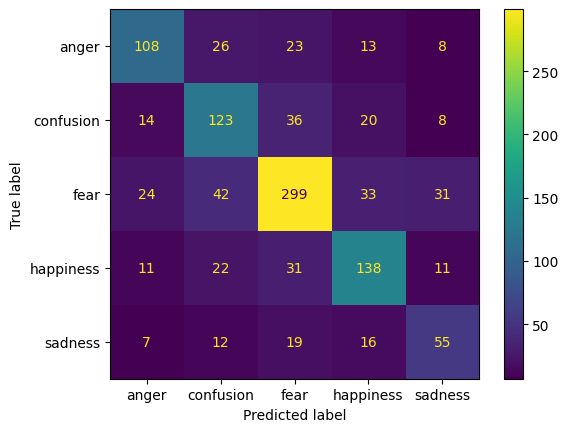

In [71]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()

## Ensembling

In [32]:
log_clf = LogisticRegression(random_state=42)
nb_clf = MultinomialNB()

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('nb', nb_clf)], voting='soft')

model = make_pipeline(CountVectorizer(), voting_clf)

## Cross validation

In [73]:
scoring = 'f1_macro'
scores = cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs = -1)
print(f"Mean {scoring}: {scores.mean()}")
print(f"Standard deviation {scoring}: {scores.std()}")

Mean f1_macro: 0.6001557737977311
Standard deviation f1_macro: 0.016848071616025688


## Optimize hyperparameters using Grid Search

In [74]:
model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'))

param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score:", test_score)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'logisticregression__C': 1, 'logisticregression__penalty': 'l1'}
Best cross-validation score: 0.7450944180698572
Test set score: 0.7858407079646018
